### The Data

The dataset below is from [kaggle]() and contains a dataset named the "ColBert Dataset" created for this [paper](https://arxiv.org/pdf/2004.12765.pdf).  You are to use the text column to classify whether or not the text was humorous.  It is loaded and displayed below.

**Note:** The original dataset contains 200K rows of data. It is best to try to use the full dtaset. If the original dataset is too large for your computer, please use the 'dataset-minimal.csv', which has been reduced to 100K.

In [16]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
import time
import matplotlib.pyplot as plt

# Download necessary resources from NLTK
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/victorjoseph/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/victorjoseph/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
dataset_full = pd.read_csv('text_data/dataset.csv')

In [11]:
dataset_full.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits


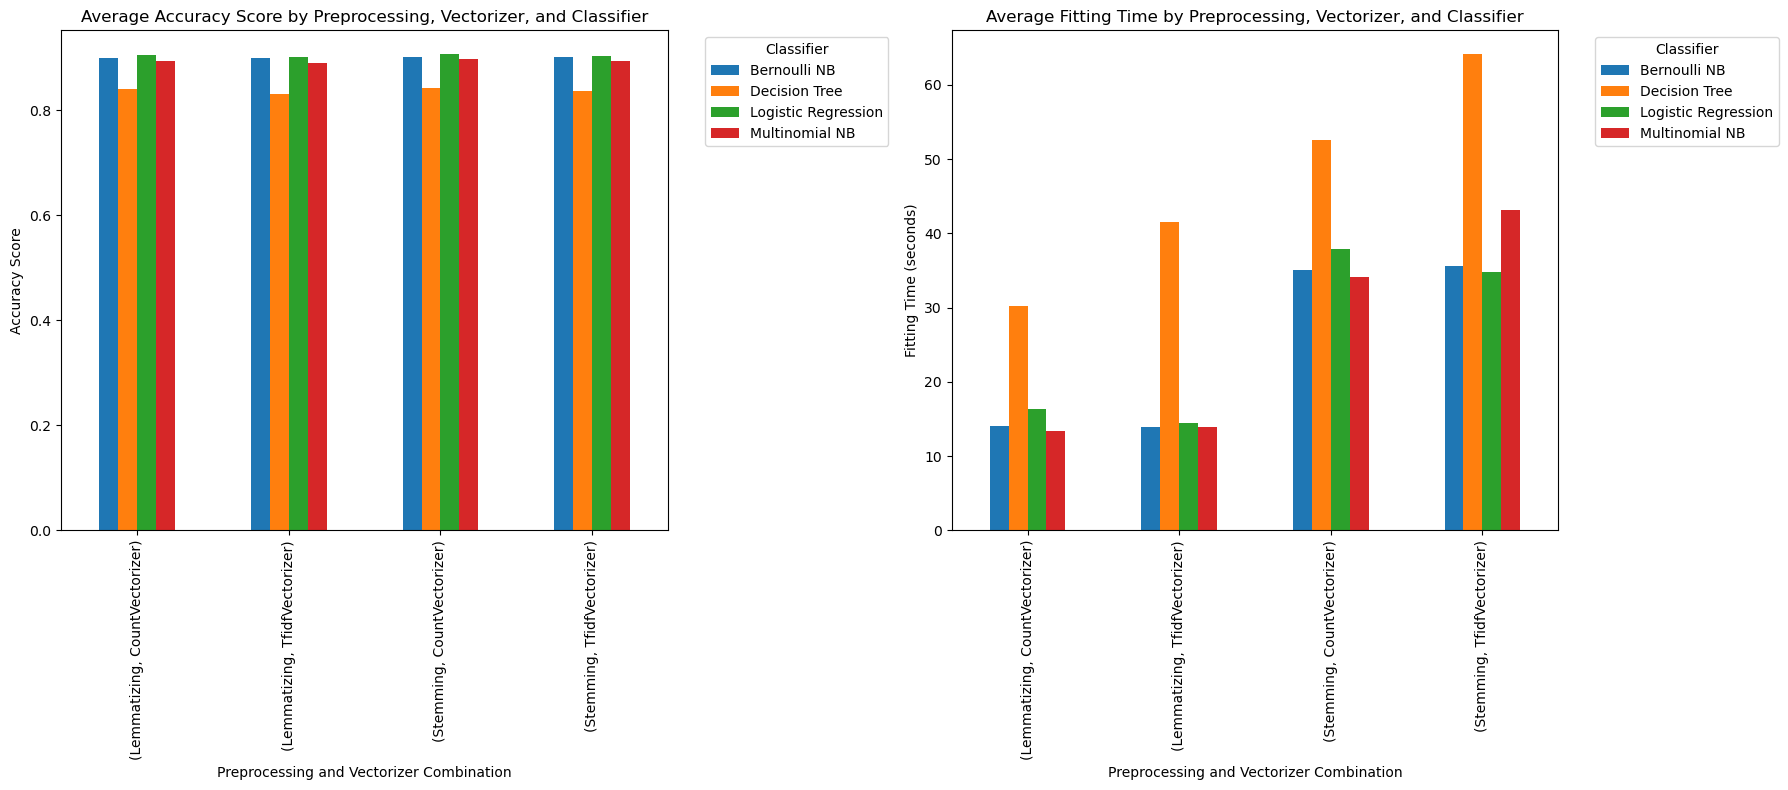

In [21]:
# Define custom transformers for stemming and lemmatizing
class Stemmer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = SnowballStemmer('english')

    def transform(self, X, *_):
        return [' '.join([self.stemmer.stem(word) for word in text.split()]) for text in X]

    def fit(self, *_):
        return self

class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def transform(self, X, *_):
        return [' '.join([self.lemmatizer.lemmatize(word) for word in text.split()]) for text in X]

    def fit(self, *_):
        return self

# Sample a smaller subset of the data to reduce computation time
dataset_sampled = dataset_full.sample(n=50000, random_state=42)  # Adjust the 'n' value as needed to further reduce data size

# Prepare train-test split
X = dataset_sampled['text']
y = dataset_sampled['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define vectorizers and classifiers
vectorizers = [CountVectorizer(), TfidfVectorizer()]
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Multinomial NB', MultinomialNB()),
    ('Bernoulli NB', BernoulliNB())
]

# Loop through each preprocessing, vectorizer, and classifier combination and evaluate
pipeline_results = []

preprocessing_steps = [
    ('Stemming', Stemmer()),
    ('Lemmatizing', Lemmatizer())
]

for step_name, preprocessor in preprocessing_steps:
    for vectorizer in vectorizers:
        for name, classifier in classifiers:
            # Define pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),  # Preprocessing step (stemming or lemmatizing)
                ('vectorizer', vectorizer),
                ('classifier', classifier)
            ])
            
            # Define parameter grid
            param_grid = {
                'vectorizer__max_features': [1000, 3000],  # Limit vocabulary size to reduce complexity
                'vectorizer__stop_words': [None, 'english']  # With and without stopwords
            }

            # Initialize GridSearchCV
            grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)  # Reduce cv folds to 3

            # Measure fitting time
            start_time = time.time()
            grid_search.fit(X_train, y_train)
            elapsed_time = time.time() - start_time
            
            # Store the best parameters, score, and fitting time
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            
            pipeline_results.append((step_name, vectorizer.__class__.__name__, name, best_params, best_score, elapsed_time))

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(pipeline_results, columns=['Preprocessing', 'Vectorizer', 'Classifier', 'Best Parameters', 'Best Score', 'Fitting Time (seconds)'])

# Save the results to a CSV file if needed
results_df.to_csv('classification_results.csv', index=False)

# Visualization using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plotting Best Score for Each Classifier
results_grouped = results_df.groupby(['Preprocessing', 'Vectorizer', 'Classifier'])['Best Score'].mean().unstack()
results_grouped.plot(kind='bar', ax=axes[0], title='Average Accuracy Score by Preprocessing, Vectorizer, and Classifier')
axes[0].set_ylabel('Accuracy Score')
axes[0].set_xlabel('Preprocessing and Vectorizer Combination')
axes[0].legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plotting Fitting Time for Each Classifier
results_grouped_time = results_df.groupby(['Preprocessing', 'Vectorizer', 'Classifier'])['Fitting Time (seconds)'].mean().unstack()
results_grouped_time.plot(kind='bar', ax=axes[1], title='Average Fitting Time by Preprocessing, Vectorizer, and Classifier')
axes[1].set_ylabel('Fitting Time (seconds)')
axes[1].set_xlabel('Preprocessing and Vectorizer Combination')
axes[1].legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
